<a href="https://colab.research.google.com/github/gracecarrillo/Political-Data-Science/blob/master/Model_Evaluation_Sentiment_Analysis_Scotref2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scottish independence: Twitter data Sentiment Analysis



### 6. Model Evaluation
  - Confusion Matrix
  - Accuracy, Recall, Precision and F1-Scores

In [0]:
# Must be upgraded
!pip install tqdm==4.36.1 --upgrade

In [0]:
!pip install tweet_parser

In [0]:
!pip install --upgrade gensim

In [0]:
!pip install vaderSentiment

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [107]:
# general
import os
import pandas as pd
import numpy as np
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import collections
from collections import Counter

# tweets
import tweepy as tw
import re
from collections import Counter
from string import punctuation
from tweepy import OAuthHandler
import json

# text manipulation 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import * 

# plots
from wordcloud import WordCloud
import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

# Feature Engineering
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Evaluation
from numpy import loadtxt
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# For geoplots
from IPython.display import IFrame
import folium
from folium import plugins
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMapWithTime
import networkx

# set plot preferences
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option("display.max_colwidth", 200) 

# hide warnings
import warnings
warnings.filterwarnings("ignore")

print('Libraries imported')
%matplotlib inline

Libraries imported


## 7. Evaluation

To get intuition about models capacity, we will look deeper into the following metrics:

- Confusion Matrix
- Accuracy, Recall, Precision and F1-Scores


First, we must import all our model's predictions and test data:

In [18]:
# Set up labels
labels = LabelEncoder().fit(['negative', 'positive'])

# Import supervised learning model predictions
y_pred_nb = np.load('/content/drive/My Drive/Twitter_Project/y_predsNB.npy')
y_pred_svm = np.load('/content/drive/My Drive/Twitter_Project/y_predsSVM.npy')

# Import supervised learning models test data
y_test = np.load('/content/drive/My Drive/Twitter_Project/y_test.npy')

# Import deep learning predictions
y_preds_LSTM = np.load('/content/drive/My Drive/Twitter_Project/y_predsLSTM.npy')
y_preds_LSTMreg = np.load('/content/drive/My Drive/Twitter_Project/y_predsLSTMreg.npy')

# To output vector of labels for confusion matrix
y_preds_LSTM = np.argmax(y_preds_LSTM, axis=1)
y_preds_LSTMreg = np.argmax(y_preds_LSTMreg, axis=1)

# Import deep learning test data
Y_test = np.load('/content/drive/My Drive/Twitter_Project/y_testLSTM.npy')
Y_test = np.argmax(Y_test, axis = 1)

print('Predictions and test data imported')

Predictions and test data imported



### 7.1 Confusion Matrices

With the help of the following functions (source code: [notebook](https://github.com/vtoliveira/advanced-data-science-capstone/blob/master/Model%20Evaluation%20(Deep%20Learning%20and%20Classical%20Algorithms)%20-%20Twitter%20US%20Airline%20Sentiment.ipynb)) we'll plot an analyse the Confusion Matrices.

In [0]:
# Confusion Matrix helper function
plt.style.use(style='ggplot')
plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


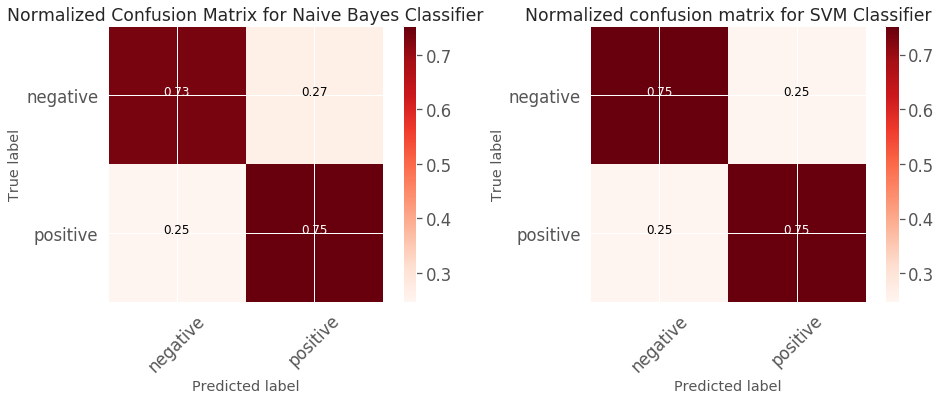

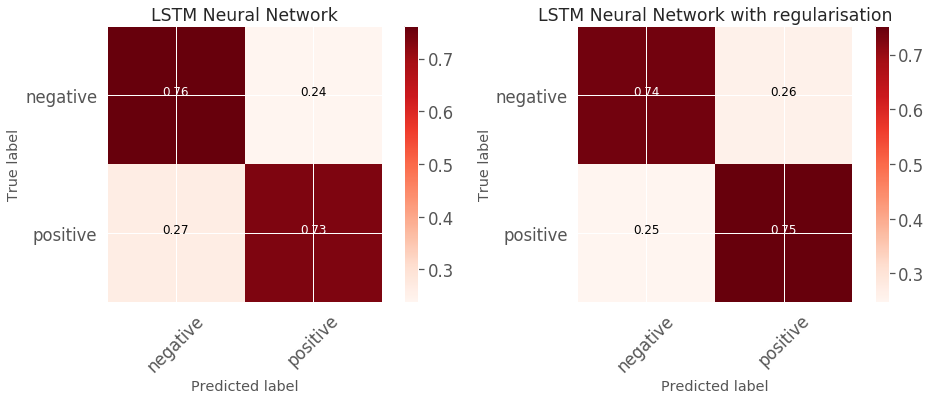

In [110]:
#--- Naive Bayes Classifier ---#

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_nb)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig = plt.figure(figsize=(20,15))
fig.add_subplot(3,3,1)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'positive'], normalize=True,
                      title='Normalized Confusion Matrix for Naive Bayes Classifier')

#--- Support Vector Machine Classifier ---#

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_svm)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig.add_subplot(3,3,2)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'positive'], normalize=True,
                      title='Normalized confusion matrix for SVM Classifier')


#--- LSTM Recurrent Neural Network ---#

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, y_preds_LSTM)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig = plt.figure(figsize=(20,15))
fig.add_subplot(3,3,1)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'positive'], normalize=True,
                      title='LSTM Neural Network')

#--- LSTM Recurrent Neural Network with regularisation ---#

# Compute confusion matrix

cnf_matrix = confusion_matrix(Y_test, y_preds_LSTMreg)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
fig.add_subplot(3,3,2)
plot_confusion_matrix(cnf_matrix, classes=['negative', 'positive'], normalize=True,
                      title='LSTM Neural Network with regularisation')

plt.savefig('/content/drive/My Drive/Twitter_Project/ConfusionMatrices.png', bbox_inches='tight')
plt.show()

### From the confusion matrices:

- **Naive Bayes Classifier**: The model predicted 76% of labels correctly as negative and 73% correctly as positive. The model predicted 27% of the labels as negative, but they were positive (false negatives). The model predicted 24% of the labels as positive when they were negative (false postive).

- **SVM Classifier**: The model predicted 75% of labels correctly as negative and 75% correctly as positive. The model predicted 25% of the labels as negative, but they were positive (false negatives). The model predicted 25% of the labels as positive when they were negative (false postive).

- **LSTM Neural Network**: The model predicted 76% of labels correctly as negative and 73% correctly as positive. The model predicted 27% of the labels as negative, but they were positive (false negatives). The model predicted 24% of the labels as positive when they were negative (false postive).

- **LSTM Neural Network with Regularisation**: The model predicted 74% of labels correctly as negative and 73% correctly as positive. The model predicted 25% of the labels as negative, but they were positive (false negatives). The model predicted 26% of the labels as positive when they were negative (false postive), which is a bit of an improvement in accuracy over the first RNN model.

### 7.2 Accuracy, Recall, Precision and F1-Scores

Now we generate a classification report. We'll save it as a pandas dataframe for better formatting, with the help of a helper function (modified from source code [here](https://gist.github.com/wassname/f3cbdc14f379ba9ec2acfafe5c1db592)).

In [0]:
# Helper function for Classification Report 

def classification_report_asdf(test, pred, output_dict=True):
  ''' ------------------------------
  Function to return a classification report 
  as dataframe, with rounded scores. 
  --- Parameters:----
  test = test data as array
  pred = prediction data array
  output_dic = set to True
  ------------------------
  '''
  # extract scores as dictionary
  report = classification_report(test,pred, output_dict=output_dict)
  df_report = pd.DataFrame(report).transpose()
  #round
  df_report[["precision","recall","f1-score"]]= df_report[["precision","recall","f1-score"]].apply(lambda x: round(x,2))
  df_report[["support"]]= df_report[["support"]].apply(lambda x: x.astype(np.int))
  # Add suport to avg
  df_report.loc['accuracy', 'support'] = df_report.loc['weighted avg', 'support']

  return df_report

In [98]:
# Classification reports for Supervised ML models

#--- Naive Bayes Classifier ----#
report_nb = classification_report_asdf(y_test, y_pred_nb)

#--- SVM Classifier ----#
report_svm = classification_report_asdf(y_test, y_pred_svm)

#--- Add reports together ----#
SML_dfs = [report_nb, report_svm]

SML_dfs_combined = pd.concat(
    [df.rename(columns=lambda x: x.zfill(4)) for df in SML_dfs],
    keys=['Naive Bayes Classifier', 'SVM Classifier'],
    axis=1
)

# Show reports
SML_dfs_combined

Naive Bayes Classifier                  ... SVM Classifier                 
                          precision recall f1-score  ...         recall f1-score support
0                              0.75   0.73     0.74  ...           0.75     0.75    7313
1                              0.73   0.75     0.74  ...           0.75     0.75    7035
accuracy                       0.74   0.74     0.74  ...           0.75     0.75   14348
macro avg                      0.74   0.74     0.74  ...           0.75     0.75   14348
weighted avg                   0.74   0.74     0.74  ...           0.75     0.75   14348

[5 rows x 8 columns]

In [100]:
# Classification report for RNN models

#---- LSTM Network ----#
report_LSTM = classification_report_asdf(Y_test, y_preds_LSTM)

#---- LSTM Network with regularisation ----#
report_LSTMreg = classification_report_asdf(Y_test, y_preds_LSTMreg)


#--- Add reports together ----#
RNN_dfs = [report_LSTM, report_LSTMreg]

RNN_dfs_combined = pd.concat(
    [df.rename(columns=lambda x: x.zfill(4)) for df in RNN_dfs],
    keys=['LSTM Network', 'LSTM Network with regularisation'],
    axis=1
)

# Show reports
RNN_dfs_combined

LSTM Network                  ... LSTM Network with regularisation                 
                precision recall f1-score  ...                           recall f1-score support
0                    0.75   0.76     0.75  ...                             0.74     0.75    4860
1                    0.75   0.73     0.74  ...                             0.75     0.74    4705
accuracy             0.75   0.75     0.75  ...                             0.74     0.74    9565
macro avg            0.75   0.75     0.75  ...                             0.74     0.74    9565
weighted avg         0.75   0.75     0.75  ...                             0.74     0.74    9565

[5 rows x 8 columns]

### From the classification reports:

- **Naive Bayes Classifier**: 
  - *Precision (Accuracy of positive predictions)*: 75% for label negative and 75% for positive. This number tells us what proportion of fraction of predicted positive events that are actually positive .

  - *Recall (aka sensitivity or true positive rate)*: 76% for negative and 73% for positive label. This is the number of correct predictions out of true labels for that class.

  - *F1-Score (2 x (precision x recall)/(precision + recall)*: This is the weighted average of precision and recall for that class. It generally gives the bigger picture of how the model is performing for that label. The higher this number is the better. We have  75% for label negative and 74% for label postive.

  - *Accuracy*: 74% is the number of times the model predicted the correct label over all labels in the dataset. This is most common metric for classification and shows the proportion of samples predicted correctly. When the distribution of the classes in data is well balanced, accuracy can give us a good picture of how the model is performing.

  - *Support*: This is just the number of samples of the true response that lie in that class. 
<br>

- **SVM Classifier**: 
  - *Precision*: 76% for label negative and 74% for positive.

  - *Recall*: 74% for negative and 75% for positive label.

  - *F1-Score*: 75% for label negative and 74% for label postive.

  - *Accuracy*: 75%
  <br>

- **LSTM Neural Network**: 
  - *Precision*: 75% for label negative and 75% for positive.

  - *Recall*: 76% for negative and 73% for positive label.

  - *F1-Score*: 75% for label negative and 74% for label postive.

  - *Accuracy*: 75%
  <br>

- **LSTM Neural Network with regularisation**: 
  - *Precision*: 75% for label negative and 74% for positive.

  - *Recall*: 74% for negative and 75% for positive label.

  - *F1-Score*: 75% for label negative and 74% for label postive.

  - *Accuracy*: 74%

### Choosing a model.

From the above metrics, our models seem to be performing relatively well.

According to research [human raters typically agree 80% of the time.](http://www.mecs-press.org/ijeme/ijeme-v7-n1/IJEME-V7-N1-3.pdf).

Therefore a 75% accurate program is doing almost as good as humans, even though such accuracy may not seem all that impressive. If a program were 'right' 100% of the time, humans would still disagree with it.

We can also benchmark our model against [similar work](https://www-sciencedirect-com.ezproxy.napier.ac.uk/science/article/pii/S1877050917328089). The final model was based on Support Vector Machine and went on to achieve an accuracy of 79.08%, which is not far from our models' results.

Both SVM and LSTM netword classifier without regularisation outperformed the other models by 1%, achieving 75% accuracy.

Thus, the performance of SVM is found to be better than other models and is the one we will use for our next steps.

Ultimately the true test is testing the model on unseen, real world data.

We will now run sentiment predictions with our chosen model on the data we acquired during ETL via the twitter API and evaluate its performance.